# Boundary behaviour tutorial
In many parcels simulations particles end up moving onto parts of the grid where the velocity field is not defined because it is part of a solid. Particles drifting on a model surface ocean move onto land cells for example. In this tutorial we look at how this happens in different velocity fields. Based on this we showcase some options on how to treat the particles that leave the model domain across these solid-fluid boundaries.

The tutorial first looks at how velocity fields are structured and what that means for where the solid-fluid boundaries are located. Then we will look at the different options to manage particle behaviour at the boundaries. 
<!-- Finally we benchmark the different options to assess the qualities of the different options. -->

* [Velocity fields](#Velocity-fields)
    * [A grids](#A-grids)
    * [C grids](#C-grids)
* [Boundary solutions](#Boundary-solutions)
    * [Plain parcels output](#Plain-parcels)
    * [Flag on land](#Flag-on-land-cells)
    * [Parabolic profile](#Parabolic-profile)
    * [Nudging current](#Nudging-steps)
    * [Stochastic beaching](#Stochastic-beaching)
<!-- * [Benchmarking](#Benchmarking) -->
* [References](#References)

In [2]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4

import numpy as np
import xarray as xr
from datetime import timedelta as delta

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Velocity fields
The velocity fields used to advect particles in Parcels may come from different types of models. Model boundaries are defined at the moment Boundary Conditions are introduced in a numerical problem or sometimes when an analytical solution is discretised onto a numerical grid. To correctly simulate the Lagrangian trajectory near any solid-fluid boundary it is important to understand two things:
1. Whether and how a model permits fluid trajectories to cross the model boundary
2. How the Boundary Conditions can affect the location of the boundary relative to the known velocity grid.

### Crossing model boundaries
Many ocean models are mass-conserving, meaning that the boundary conditions are formulated in such a way that the entire fluid stays inside the model domain: the boundary conditions usually state that the velocity component normal to the boundary is zero at the boundary. If this type of velocity field is used as input for parcels, we should expect that only numerical errors can lead to particle trajectories crossing the model boundary. 

In some cases however, the velocity field permits cross-boundary flow. An example of this is the wind-stress field that causes the Stokes drift of particles. The wind field does not necessarily care about the model domain and can push particles onto the coast. Another example may be a very high-resolution fluid model in which permeable boundaries exist. This tutorial is mainly focussed on velocity fields that are mass-conserving within the parcels domain. If the velocity field consists of multiple components, like currents and Stokes drift, some of the solutions in tutorial may be applicable only to the mass-conserving field, while others affect both fields.

### Location of the boundary - consequences for Parcels

The velocity field that you pass into the parcels framework using [`parcels.FieldSet`](https://oceanparcels.org/gh-pages/html/#module-parcels.fieldset) only consists of the velocity data and the coordinates of the grid points in physical space. The only boundaries that parcels "sees" are grid points at which the velocity vector is zero. Because of the bilinear interpolation that parcels uses in the entire domain, the particle velocity only goes to zero when the four (2D) or eight (3D) nearest velocity vectors are zero. The model boundary is not necessarily defined at the grid points where the velocity is zero. Here we take a look at two common model grids and the consequences of some common boundary conditions for parcels trajectories.

#### A grids
Arakawa A grids are unstaggered grids where the velocities u, v (and w), pressure and other tracers are defined at the same position. These nodes can be located at the center or the edges of the grid cells. This means that the cell boundaries, and therefore the solid-fluid boundaries can either be located between the nodes or at the nodes respectively (see figure below). Where the nodes are positioned with respect to the boundaries is determined by the type of Boundary Condition. Nodes are at cell corners when using a [Dirichlet boundary condition](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition) where the values of one or multiple variables are defined at the boundary. On the other hand, when a [Neumann boundary condition](https://en.wikipedia.org/wiki/Neumann_boundary_condition) is imposed, which specifies the derivative of a variable at the boundary, the nodes may be placed at the center of grid cells which allows the derivative to be formulated more precisely at the boundary.

Assuming that the most often used boundary condition in fluid dynamics models states that the normal-component of the velocity goes to zero at the boundary we can conclude that usually a Dirichlet boundary condition is used and the nodes are positioned at the corners of cells (**figure A** below). This is compatible with the way in which parcels interpolates A grids: The particle velocity is interpolated from the four surrounding nodes, which means that when a particle enters a solid grid cell the four surrounding nodes are all zero and the particle is stuck on land or 'beached'. To improve the parcels simulation we should be able to implement the boundary condition in Parcels (see [Parabolic profile](#Parabolic-profile)).

There are two important exceptions to the case where Dirichlet boundary conditions are implemented in this way. The first is when an analytical solution is discretised onto a numerical grid. This is done in [example_peninsula.py](https://github.com/OceanParcels/parcels/blob/master/parcels/examples/example_peninsula.py). In this case the boundary is located at an exact curve between the nearest solid and fluid nodes. To implement the correct boundary conditions in this case is very hard I imagine.

The other exception is likely to occur more often. Many ocean models are run on a C grid, because boundary conditions are more straightforward to implement there (see [C grid](#C-grids)). Often the output of these models is interpolated onto an A grid. Since the pressure and tracers are defined at the center of grid cells in a C grid, I suspect the velocities to be interpolated onto these centers as well. This seems the easiest way to define all variables at the same position. This interpolation is also done in [in parcels](https://gmd.copernicus.org/articles/12/3571/2019/#bib1.bibx10) for C grids. In this case, the boundaries are located in between nodes (see **figure B**). This would mean that a particle in parcels can be in a solid grid cell and be incorrectly advected. Note how the boundary condition is indeed imposed at the cell boundary in a [C grid](#C-grids). This again has consequences for the corrections we should make. 

In [3]:
afields = xr.open_dataset('Peninsula_data/peninsulaU.nc')

dx = afields['x'][1]-afields['x'][0]
dy = afields['y'][1]-afields['y'][0]
x_corners, y_corners = np.meshgrid(np.arange(afields['x'].values[0]-0.5*dx, afields['x'].values[-1]+1.5*dx, dx),
                np.arange(afields['y'].values[0]-0.5*dy, afields['y'].values[-1]+0.5*dy, dy))
x_centers, y_centers = np.meshgrid(np.arange(afields['x'].values[0], afields['x'].values[-1]+dx, dx),
                np.arange(afields['y'].values[0], afields['y'].values[-1], dy))
cells = np.zeros((len(afields['y'])-1,len(afields['x'])-1))

### Create seethrough colormap to show different grid interpretations
cmap = plt.get_cmap('Blues')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = 0
my_cmap = ListedColormap(my_cmap)

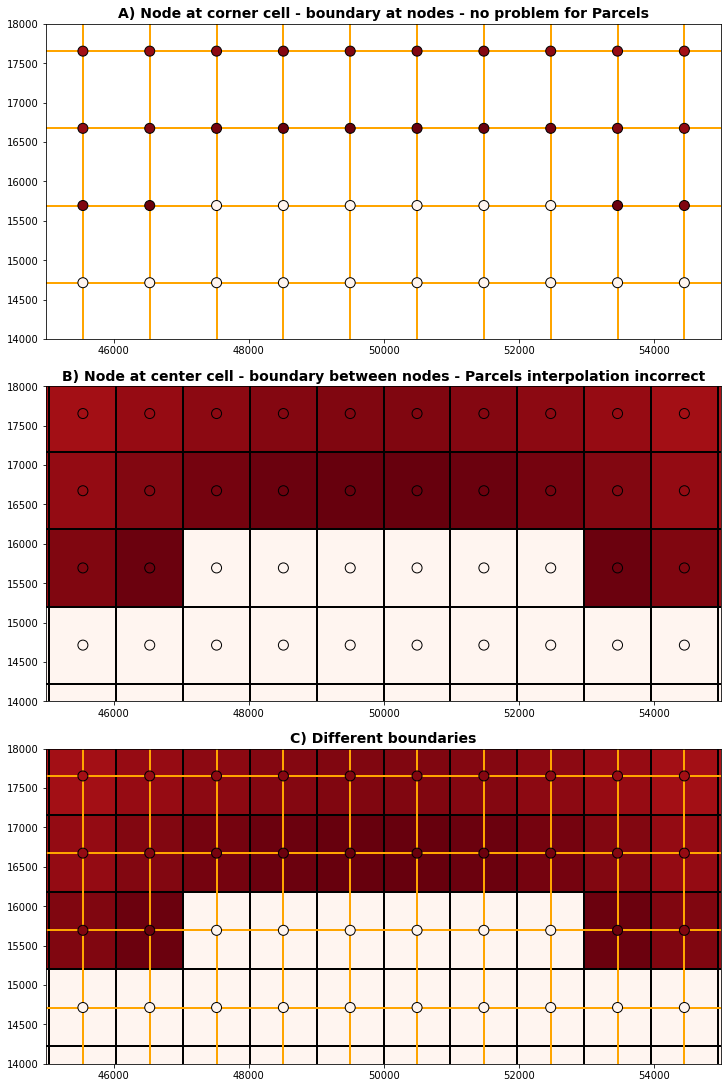

In [4]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,15),constrained_layout=True)

ax1.set_xlim(45000, 55000)
ax1.set_ylim(14000, 18000)
ax1.set_title('A) Node at corner cell - boundary at nodes - no problem for Parcels', fontsize=14, fontweight = 'bold')
ax1.pcolormesh(x_centers,y_centers,cells,cmap=my_cmap,edgecolors='orange')
ax1.scatter(x_centers,y_centers,s=100,c=afields['vozocrtx'][0,0],cmap='Reds',edgecolors='k')

ax2.set_xlim(45000, 55000)
ax2.set_ylim(14000, 18000)
ax2.set_title('B) Node at center cell - boundary between nodes - Parcels interpolation incorrect', fontsize=14, fontweight = 'bold')
ax2.pcolormesh(x_corners,y_corners,afields['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax2.scatter(x_centers,y_centers,s=100,c=afields['vozocrtx'][0,0],cmap='Reds',edgecolors='k')

ax3.set_xlim(45000, 55000)
ax3.set_ylim(14000, 18000)
ax3.set_title('C) Different boundaries', fontsize=14, fontweight = 'bold')
ax3.pcolormesh(x_corners,y_corners,afields['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax3.pcolormesh(x_centers,y_centers,cells,cmap=my_cmap,edgecolors='orange')
ax3.scatter(x_centers,y_centers,s=100,c=afields['vozocrtx'][0,0],cmap='Reds',edgecolors='k')

##### Analytical solution discretized
The following demonstrates particles getting stuck on the model domain of an analytical solution discretised onto an A grid

In [3]:
fieldset = FieldSet.from_parcels("Peninsula_data/peninsula", allow_time_extrapolation=True)

npart = 10  # number of particles to be released
lon = 4e4 * np.ones(npart)
lat = np.linspace(11e3 , 14e3, npart, dtype=np.float32)
time = np.zeros(npart)

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, time=time)

output_file = pset.ParticleFile(name="Agrid-stuck.nc", outputdt=delta(hours=1))
pset.execute(AdvectionRK4, runtime=delta(hours=10), dt=delta(minutes=5),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled JITParticleAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\57ef2d26555c295e200725f64bef9bed_0.dll


In [4]:
data = xr.open_dataset('Agrid-stuck.nc')

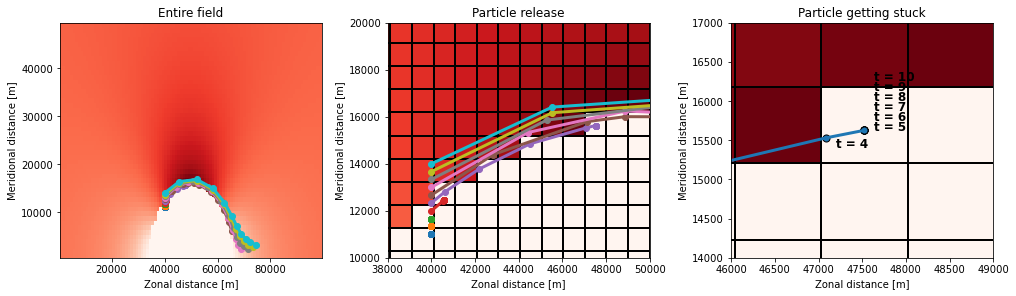

In [7]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4),constrained_layout=True)

ax1.set_ylabel('Meridional distance [m]')
ax1.set_xlabel('Zonal distance [m]')
ax1.set_title('Entire field')

ax1.pcolormesh(x_corners,y_corners,afields['vozocrtx'][0,0],cmap='Reds')
ax1.plot(data['lon'].T, data['lat'].T,marker='o',linewidth=3)

ax2.set_ylabel('Meridional distance [m]')
ax2.set_xlabel('Zonal distance [m]')
ax2.set_title('Particle release')
ax2.set_xlim(38000, 50000)
ax2.set_ylim(10000, 20000)

ax2.pcolormesh(x_corners,y_corners,afields['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax2.plot(data['lon'].T, data['lat'].T,marker='o',linewidth=3)

ax3.set_ylabel('Meridional distance [m]')
ax3.set_xlabel('Zonal distance [m]')
ax3.set_title('Particle getting stuck')
ax3.set_xlim(46000, 49000)
ax3.set_ylim(14000, 17000)

ax3.pcolormesh(x_corners,y_corners,afields['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
# ax3.pcolormesh(x_centers,y_centers,cells,cmap=my_cmap,edgecolors='orange')
ax3.plot(data['lon'].sel(traj=4), data['lat'].sel(traj=4),linewidth=3)
ax3.scatter(data['lon'].sel(traj=4), data['lat'].sel(traj=4),s=50,edgecolor='k')
for i, txt in enumerate(data['obs']):
    if data['lon'].sel(traj=4)[i]>46000:
        ax3.annotate('t = '+str(txt.values), (data['lon'].sel(traj=4)[i], data['lat'].sel(traj=4)[i]), xytext=(10, 10*(i-4)-10), textcoords='offset points',fontsize=12, weight='bold')

#### C grids

On staggered grids, different types of boundary conditions can be satisfied simultaneously. 

In [5]:
cufields = xr.open_dataset('NemoNorthSeaORCA025-N006_data/ORCA025-N06_20000104d05U.nc')
cvfields = xr.open_dataset('NemoNorthSeaORCA025-N006_data/ORCA025-N06_20000104d05V.nc')

xu_corners, yu_corners = np.meshgrid(np.arange(cufields['x'].values[0], cufields['x'].values[-1]+1, 1),
                np.arange(cufields['y'].values[0]-0.5, cufields['y'].values[-1]+0.5, 1))
xv_corners, yv_corners = np.meshgrid(np.arange(cvfields['x'].values[0]-0.5, cvfields['x'].values[-1]+0.5, 1),
                np.arange(cvfields['y'].values[0], cvfields['y'].values[-1]+1, 1))
fx_corners, fy_corners = np.meshgrid(np.arange(cufields['x'].values[0]-1, cufields['x'].values[-1]+1, 1),
                np.arange(cufields['y'].values[0]-1, cufields['y'].values[-1]+1, 1))
cells = np.zeros((len(cufields['y']),len(cufields['x'])))

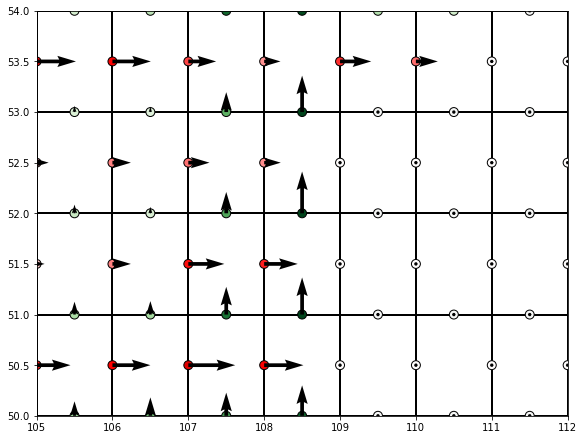

In [6]:
fig = plt.figure(figsize=(8,6),constrained_layout=True)
ax1=plt.axes()

ax1.set_xlim(105, 112)
ax1.set_ylim(50, 54)
ax1.pcolormesh(fx_corners,fy_corners,cells,cmap=my_cmap,edgecolors='k',linewidth=1)
ax1.scatter(xu_corners,yu_corners, s=80,c=cufields['uos'][0],cmap='seismic',vmin=-0.1,vmax=0.1,edgecolor='k')
ax1.scatter(xv_corners,yv_corners, s=80,c=cvfields['vos'][0],cmap='PRGn',vmin=-0.1,vmax=0.1,edgecolor='k')
ax1.quiver(xu_corners,yu_corners,cufields['uos'][0],np.zeros(xu_corners.shape),angles='xy', scale_units='xy', scale=0.1, width=0.007)
ax1.quiver(xv_corners,yv_corners,np.zeros(xv_corners.shape),cvfields['vos'][0],angles='xy', scale_units='xy', scale=0.3, width=0.007)



In [ ]:
# from glob import glob

# data_path = 'NemoNorthSeaORCA025-N006_data/'
# ufiles = sorted(glob(data_path+'ORCA*U.nc'))
# vfiles = sorted(glob(data_path+'ORCA*V.nc'))
# wfiles = sorted(glob(data_path+'ORCA*W.nc'))
# mesh_mask = data_path + 'coordinates.nc'

# filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
#              'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
#              'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles}}

# variables = {'U': 'uo',
#              'V': 'vo',
#              'W': 'wo'}
# dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
#               'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
#               'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

# fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

# npart = 10  # number of particles to be released
# lon = 4e4 * np.ones(npart)
# lat = np.linspace(11e3 , 14e3, npart, dtype=np.float32)
# time = np.zeros(npart)

# pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, time=time)

# output_file = pset.ParticleFile(name="Cgrid-stuck.nc", outputdt=delta(hours=1))
# pset.execute(AdvectionRK4, runtime=delta(hours=10), dt=delta(minutes=5),
#              output_file=output_file)
# output_file.close()  # export the trajectory data to a netcdf file

## Boundary solutions

### Flag on land cells

### Parabolic profile

### Nudging steps

### Stochastic beaching

## Benchmarking

## References

Cushman-Roisin, B., & Jean-Marie, B. (2011). Introduction to Geophysical Fluid Dynamics: Physical and Numerical Aspects (p. 789).

Lynch, D. R., Greenberg, D. A., Bilgili, A., McGillicuddy, J., Manning, J. P., & Aretxabaleta, A. L. (2015). Particles in the Coastal Ocean Theory and Applications. Cambridge University Press. https://doi.org/10.1017/CBO9781107449336
